<a href="https://colab.research.google.com/github/flatplanet/Pytorch-Tutorial-Youtube/blob/main/simple_NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 2: Neural Network using PyTorch

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F


## Create a Model ( with three hidden layers)

In [2]:
# Create a Model Class that inherits nn.Module
class Model(nn.Module):
    def __init__(self,in_features,out_features,h1=9, h2=8, h3=7):
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2,h3)
        self.out = nn.Linear(h3, out_features)

    def forward(self,x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.relu(self.fc3(x))
      x = self.out(x)
      return x

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Correlation Analysis

In [4]:
my_df = pd.read_csv('cars.csv')

In [5]:
# replace carbody column with numeric integers
target_col = 'carbody'
my_df[target_col] = my_df[target_col].replace('convertible',0.0)
my_df[target_col] = my_df[target_col].replace('hardtop',1.0)
my_df[target_col] = my_df[target_col].replace('hatchback',2.0)
my_df[target_col] = my_df[target_col].replace('sedan',3.0)
my_df[target_col] = my_df[target_col].replace('wagon',4.0)

In [6]:
# consider only quantitative data (non categorical)
# print(my_df.select_dtypes(include='number'))
numeric_cols = ['wheelbase','carlength','carwidth','carheight','curbweight','enginesize',
                    'boreratio','stroke','compressionratio','horsepower', 'peakrpm',
                    'citympg','highwaympg','price',target_col]

# perform correlation analysis with transformed target
carbody_correlations = my_df[numeric_cols].corr()[[target_col]].abs().sort_values(by=target_col, ascending=False)
top_five_correlations = carbody_correlations.head(6)

indepdent_vars = []
print("the top five columns with higest correlation with target = carbody")
for ind,val in top_five_correlations.iterrows():
  print(ind,val[target_col])
  if ind == target_col:
    continue
  indepdent_vars.append(ind)
print("\nthe resulting indepdendnet vars are ")
print(indepdent_vars)

the top five columns with higest correlation with target = carbody
carbody 1.0
carheight 0.5685343155450354
wheelbase 0.4013623316186531
carlength 0.33443343846979984
horsepower 0.15392758660996628
compressionratio 0.13624338506021347

the resulting indepdendnet vars are 
['carheight', 'wheelbase', 'carlength', 'horsepower', 'compressionratio']


## Train Test Split

In [7]:
from sklearn.model_selection import train_test_split
X = my_df.drop(target_col, axis=1)[indepdent_vars]
y = my_df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.33, random_state=42)

## Select Loss Function, optimizer, epochs

In [8]:
# Convert X features to float tensors
X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)

# Convert y labels to tensors long
y_train = torch.LongTensor(y_train.values)
y_test = torch.LongTensor(y_test.values)

model = Model(in_features=len(indepdent_vars),out_features=len(np.unique(my_df["carbody"])))

# Set the criterion of model to measure the error
criterion = nn.CrossEntropyLoss()
# Choose Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)



## Train and test the model!

In [9]:
# model training
epochs = 100
losses = []
for i in range(epochs):
  y_pred = model.forward(X_train)
  loss = criterion(y_pred, y_train)
  losses.append(loss.detach().numpy())

  # print every 10 epoch
  if i % 10 == 0:
    print(f'Epoch: {i} and loss: {loss}')

  # back propagation
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch: 0 and loss: 5.522885322570801
Epoch: 10 and loss: 1.3270331621170044
Epoch: 20 and loss: 1.213490605354309
Epoch: 30 and loss: 1.1851166486740112
Epoch: 40 and loss: 1.1669608354568481
Epoch: 50 and loss: 1.1566102504730225
Epoch: 60 and loss: 1.1503287553787231
Epoch: 70 and loss: 1.1463255882263184
Epoch: 80 and loss: 1.1429015398025513
Epoch: 90 and loss: 1.1399574279785156


## Plot the training graph - loss vs epochs

Text(0.5, 0, 'Epoch')

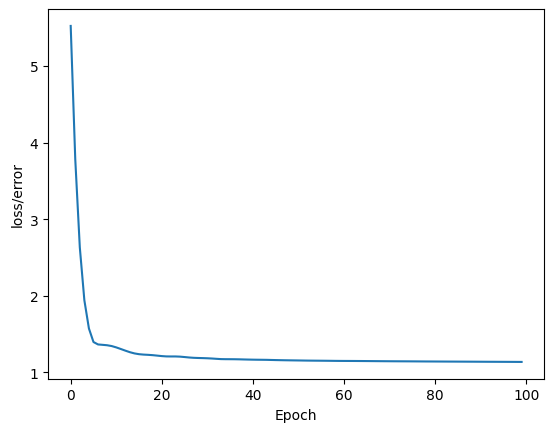

In [10]:
# Graph it out!
plt.plot(range(epochs), losses)
plt.ylabel("loss/error")
plt.xlabel('Epoch')

## Test the model on test data set and print loss performance

In [11]:
# Evaluate Model on Test Data Set
with torch.no_grad():  # Basically turn off back propogation
  y_eval = model.forward(X_test) # X_test are features from our test set, y_eval will be predictions
  loss = criterion(y_eval, y_test) # Find the loss or error
  print(loss)

tensor(1.3140)


In [12]:
correct = 0
with torch.no_grad():
  for i, data in enumerate(X_test):
    y_val = model.forward(data)

    if y_test[i] == 0.0:
      x = "convertible"
    elif y_test[i] == 1.0:
      x = 'hardtop'
    elif y_test[i] == 2.0:
      x = 'hatchback'
    elif y_test[i] == 3.0:
      x = "sedan"
    else:
      x = "wagon"

    print(f'{i+1}.)  {str(y_val)} \t {y_test[i]} \t {y_val.argmax().item()}')

    # Correct or not
    if y_val.argmax().item() == y_test[i]:
      correct +=1

print(f'We got {correct} correct!')


1.)  tensor([-1.0850,  0.2590,  1.2477,  1.0849, -0.1347]) 	 3 	 2
2.)  tensor([-1.0042, -0.3129,  1.0770,  1.0625, -0.1032]) 	 2 	 2
3.)  tensor([-1.3261, -3.3293,  0.8736,  1.4193,  0.1652]) 	 3 	 3
4.)  tensor([-1.4744, -3.6233,  0.9659,  1.5299,  0.2066]) 	 2 	 3
5.)  tensor([-1.1686, -1.9051,  0.9472,  1.2387,  0.0422]) 	 4 	 3
6.)  tensor([-1.7179, -4.1814,  1.1493,  1.7375,  0.2685]) 	 2 	 3
7.)  tensor([-1.6848, -4.1082,  1.1255,  1.7102,  0.2599]) 	 2 	 3
8.)  tensor([-1.6658, -4.0707,  1.1137,  1.6961,  0.2546]) 	 3 	 3
9.)  tensor([-1.3518, -3.3879,  0.8928,  1.4411,  0.1718]) 	 4 	 3
10.)  tensor([-1.8904, -4.5280,  1.2586,  1.8678,  0.3163]) 	 3 	 3
11.)  tensor([-1.1688, -2.9835,  0.7613,  1.2903,  0.1240]) 	 3 	 3
12.)  tensor([-1.7745, -4.2971,  1.1860,  1.7809,  0.2840]) 	 2 	 3
13.)  tensor([-1.0279, -1.7607,  0.8463,  1.1451,  0.0107]) 	 3 	 3
14.)  tensor([-1.2697, -3.2103,  0.8354,  1.3748,  0.1501]) 	 2 	 3
15.)  tensor([-1.1178,  0.1383,  1.2565,  1.1110, -0.1208

## Save our model

In [13]:
# Save our NN Model
torch.save(model.state_dict(), 'my_really_awesome_model.pt')